# Head direction attractor network


### Table of contents

1. [**Synthetic population**](#synthetic)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)

This notebook contains code for:
- running GPLVM on synthetic HDC activity with a latent variable on the ring
- running GPLVM or Deep GPs on synthetic place field activity for decoding position
- running conditional GPLVM on place field synthetic data

In [7]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

import pickle



import sys
sys.path.append("../lib")

import neuroprob as nprb
from neuroprob import utils



dev = nprb.inference.get_device()

plt.style.use(['../paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.13.0+cu117
Using device: cuda:0


<a id="synthetic"></a>
## Synthetic HDC population

In [16]:
# Gaussian von Mises bump head direction model
trials = 3

track_samples = 20000
hd_t = np.empty((trials, track_samples))

hd_t[:, 0] = np.random.rand(trials)*2*np.pi
rn = np.random.randn(trials, track_samples-1)
for k in range(track_samples-1):
    hd_t[:, k+1] = hd_t[:, k] + 0.05*rn[:, k]
    
hd_t = hd_t % (2*np.pi)

In [17]:
neurons = 50
p_c = np.random.randn(neurons)**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*np.random.randn(neurons))
p_b = 0.2*np.random.randn(neurons)**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

rate = p_a[None, :, None]*np.exp((np.cos(hd_t[:, None, :] - p_z[None, :, None])-1)/p_b[None, :, None]) + p_c[None, :, None]

In [18]:
# IPP spike trains
sample_bin = 0.001
res = torch.poisson(torch.tensor(rate*sample_bin)).numpy()

res_ind = [] # spike times
for tr in range(trials):
    res_ind_ = []
    for n in range(neurons):
        res_ind_.append(utils.neural.binned_to_indices(res[tr, n, :]))
    res_ind.append(res_ind_)

# bin data
bin_size = 20

rc_t = []
rhd_t = []
for tr in range(trials):
    tbin, resamples, rc_t_, (rhd_t_,) = utils.neural.bin_data(bin_size, sample_bin, res_ind[tr], 
                                                            track_samples, (hd_t[tr],), average_behav=False)
    
    rc_t.append(rc_t_)
    rhd_t.append(rhd_t_)
    
rc_t = np.array(rc_t)
rhd_t = np.array(rhd_t)

AttributeError: module 'neuroprob.utils' has no attribute 'plot'

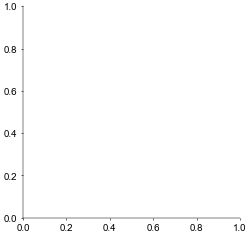

In [19]:
tr = 0

fig, ax = plt.subplots(figsize=(4,4))
utils.plot.raster_plot((fig, ax), res[tr], track_samples, sample_bin*1000, neurons, markersize=10)
utils.plot.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.figure()
plt.scatter(np.arange(track_samples), hd_t[tr], marker='.')
plt.show()

### $T^1$-GPLVM

In [17]:
out_dims = neurons
    
l = 5.*torch.ones(1, out_dims)
v = torch.ones(out_dims)

constraints = []
krn_1 = nppl.kernels.kernel.Constant(variance=v, tensor_type=torch.float)
krn_2 = nppl.kernels.kernel.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], topology='torus', f='softplus', \
    tensor_type=torch.float
)

kernel = nppl.kernels.kernel.Product(krn_1, krn_2)

p = nppl.inputs.priors.dAR1(torch.tensor(0.), torch.tensor(4.0), 'torus', 1)
v = nppl.inputs.variational.IndNormal(torch.rand(resamples, 1)*2*np.pi, torch.ones((resamples, 1))*0.1, 'torus', 1)
input_data = [nppl.inference.prior_variational_pair(1, p, v)]

num_induc = 8
Xu = torch.tensor(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(out_dims, 1, 1)
inducing_points = nppl.kernels.kernel.inducing_points(out_dims, Xu, constraints)

In [18]:
# mapping
in_dims = Xu.shape[-1]

gp_lvm = nppl.mappings.GP.SVGP(
    in_dims, neurons, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(neurons), learn_mean=True
)

In [21]:
### inputs and likelihood ###
input_group = nppl.inference.input_group()
input_group.set_XZ(input_data, resamples, batch_info=500, trials=trials)


#likelihood = mdl.likelihoods.Gaussian(neurons, 'exp', log_var=np.zeros(neurons))
likelihood = nppl.likelihoods.discrete.Poisson(tbin, neurons, 'exp')
#likelihood = mdl.likelihoods.ZI_Poisson(tbin, neurons, 'exp', 0.0*np.zeros(neurons))
likelihood.set_Y(torch.from_numpy(rc_t), batch_info=500) 


glm = nppl.inference.VI_optimized(input_group, gp_lvm, likelihood)
glm.to(dev)

VI_optimized(
  (input_group): input_group(
    (input_0): prior_variational_pair(
      (prior): dAR1(
        (transition): transition_()
      )
      (variational): IndNormal()
    )
  )
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Poisson()
)

In [22]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 5*1e-3, 
               'input_group.input_0.variational.finv_std': 5*1e-3}

glm.set_optimizers(opt_tuple, opt_lr_dict)#, 
                   #newton_grad=('rate_model.0.u_loc',), newton_lr=1e-1)
                   #nat_grad=('rate_model.0.u_loc', 'rate_model.0.u_scale_tril'), nat_lr=1e-1)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=2, ll_samples=2, ll_mode='MC')

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0

In [ ]:
X_loc, X_str = glm.input_group.input_0.variational.eval_moments(0, resamples, None)
X_loc = X_loc.data.cpu().numpy()
X_str = X_str.data.cpu().numpy()

plt.scatter(np.arange(resamples), X_loc[:] % (2*np.pi))

In [ ]:
model_name = 'GPLVM_T1R1'
checkpoint = torch.load('./checkpoint/' + model_name)
glm.load_state_dict(checkpoint['glm'])

X_loc, X_std = gp_lvm.eval_X(net_input=glm.likelihood.spikes[0])
TRlat_t, shift, sign, _ = tools.shift_circ_traj(X_loc[0], rhd_t, dev)
TRlat_t2, shift, sign, TRscale, _ = tools.shift_traj(X_loc[1], rhd_t, dev)
TRlat_std = X_std[0]
TRlat_std2 = X_std[1]

TRlen_2 = glm.rate_model[0].kernel.kern1.lengthscale.flatten().data.cpu().numpy()
TRlen_1 = glm.rate_model[0].kernel.kern0.kern1.lengthscale.flatten().data.cpu().numpy()

In [ ]:
def posterior_rate(mapping, likelihood, covariates, MC, F_dims, trials=1, percentiles=[0.05, .5, 0.95]):
    """
    Sample F from diagonalized variational posterior.
    
    :returns: F of shape (MCxtrials, outdims, time)
    """
    cov = mapping.to_XZ(covariates, trials)
    with torch.no_grad():
        if mapping.MC_only:
            F = mapping.sample_F(cov)[:, F_dims, :] # TODO: cov_samples vs ll_samples?
            samples = likelihood.f(F.view(-1, trials, *samples.shape[1:]))
        else:
            F_mu, F_var = mapping.compute_F(cov)
            samples = likelihood.sample_rate(
                F_mu[:, F_dims, :], F_var[:, F_dims, :], trials, MC)
    
    return utils.signal.percentiles_from_samples(samples, percentiles)

In [ ]:


steps= 100
show_neurons = [0, 1, 20]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

hd__ = (covariates-shift)/sign
r_true = p_a[:, None]*np.exp((np.cos(covariates[0:1, :] - p_z[:, None])-1)/p_b[:, None]) + p_c[:, None]

lower, mean, upper = gp_lvm.eval_rate(hd__, show_neurons, 'posterior', n_samp=10)
for k, neuron in enumerate(show_neurons):

    fig, ax = plt.subplots()
    ax.plot(covariates[0], r_true[neuron], 'r--')
    line, = ax.plot(covariates[0], mean[0, k])
    ax.fill_between(
        covariates[0], lower[0, k],
        upper[0, k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')

plt.show()

# draw tuning curves
samp = 10
#gp_lvm.set_params(jitter=1e-5)
gp_lvm.jitter = 1e-5
tuning = gp_lvm.eval_tuning(covariates, show_neurons, samp)

for k_n in range(len(show_neurons)):
    for n in range(samp):
        plt.plot(tuning[n, k_n, :])

    plt.show()

In [ ]:
# circular posterior
utils.plot.plot_circ_posterior(
    ax, times, wrap_y, y_std, col='k', linewidth=1., step=1, alpha=0.5, line_alpha=1., 
    l=None, l_std=None
)
    
    
    
T = 1000

fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim([0, tbin*T])
ax.set_ylim([0, 2*np.pi])
ax.set_yticks([0, 2*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$'])
ax.set_xlabel('time (s)')
ax.set_ylabel('head direction')


ax.errorbar(tbin*np.arange(T), wrap_lat_t[:T], yerr=lat_std[:T], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5 ,label='var. dist.')

X__ = wrap_lat_t[:T]+lat_std[:T]
a = np.where(X__ > 2*np.pi)[0]
ax.errorbar(tbin*np.arange(T)[a], wrap_lat_t[a]-2*np.pi, yerr=lat_std[a], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5)

X__ = wrap_lat_t[:T]-lat_std[:T]
a = np.where(X__ < 0)[0]
ax.errorbar(tbin*np.arange(T)[a], wrap_lat_t[a]+2*np.pi, yerr=lat_std[a], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5)

ax.scatter(tbin*np.arange(T), rhd_t[:T], marker='.', color='r', zorder=2, label='true latents')

ax.legend()
plt.show()


### $T^1 \times R^1$-GPLVM

In [18]:

l = 5.*torch.ones((1, neurons))
l_ = 1.*torch.ones((1, neurons))
v = torch.ones(neurons)
kernels_tuples = [('variance', v), ('SE', 'torus', l), ('SE', 'euclid', l_)]
VI_tuples = [(['RW', (0.0, 4.0, True, True)], 'Normal', 'torus', 1), 
             (['RW', (0.3, 1.0, True, False)], 'Normal', 'euclid', 1)]

num_induc = 8
inducing_points = np.array([np.linspace(0, 2*np.pi, num_induc+1)[:-1], 
                            np.linspace(-1, 1, num_induc)]).T[None, ...].repeat(neurons, axis=0)

ini_X = [
    [np.random.rand(resamples, 1)*2*np.pi, np.ones((resamples, 1))*0.1], 
    [np.random.randn(resamples, 1)*0.1, np.ones((resamples, 1))*0.01]
]





In [ ]:
ard = False
if ard:
    fig, ax = plt.subplots(figsize=(4,4))
    im = utils.plot.visualize_field((fig, ax), place_field[0], grid_shape, ticktitle='', cbar=False)


In [81]:
# CP-SVGP
if mode == 'T1xT1': # GPLVM model ARD
    pass
    
elif mode == 'T1xR1': # GPLVM model ARD
    pass
    
else: # GPLVM model
    l = 1.*np.array([np.ones(neurons)])
    v = np.ones(neurons)
    #kernels_tuples = [('variance', v), ('SE', 'torus', l)]
    K_list = [kernel.Product(
        kernel.Constant(variance=torch.tensor(v, dtype=torch.float)), 
        kernel.SE(input_dims=len(l), \
                       lengthscale=torch.tensor(l, dtype=torch.float), \
                       topology='torus'))
    ]
    in_dims = 1
    track_dims_list = [[0]]
    kernel_TT = kernel.KTT_kernel(K_list, track_dims_list)
    
    #GP_tuple = (gp_base_input, gp_base) (0.0, 1.0, False, False, *GP_tuple) RW_mapping
    VI_tuples = [(['RW', (0.0, 4.0, True, True)], 'Normal', 'torus', 1)]

    ini_X = [
        [np.random.rand(resamples, 1)*2*np.pi, np.ones((resamples, 1))*0.1]
    ]
    
    # inducing grid
    N_U = 100
    inducing_loc_list = [np.linspace(0, 2*np.pi, N_U+1)[None, None, :-1, None]]
    
    r_shape = (1,)
    nu_list = []
    Psi_list = []
    for u in inducing_loc_list:
        nu_list.append(np.zeros((neurons, *r_shape, u.shape[-2])))
        Psi_list.append(np.ones((neurons, u.shape[-2]))*1e-3)
    
    #S_list = [np.ones((neurons, u.shape[-2], u.shape[-2]))]
    #S_type = GP.linalg.general_matrix
    k_V = 3
    S_list = [np.zeros((neurons, u.shape[-2]-1))]*k_V
    S_type = GP.linalg.trilI_Toeplitz_matrix
    
    
# mapping
gp_lvm = mdl.nonparametrics.KCP_SVGP(
    in_dims, neurons, kernel_TT, inducing_loc_list, nu_list, Psi_list, S_list, S_type, 
    cheb_n=100, cheb_mc=1, GR_K=1, tr_mc=10, logdet_cheb=[True]*len(inducing_loc_list), jitter=1e-4, 
    nu_rshape_len=1, inv_link='exp', mean=np.zeros(neurons), learn_mean=True
)

In [21]:
### inputs and likelihood ###
input_group = nppl.inference.input_group()
input_group.set_XZ(input_data, resamples, batch_info=500)


#likelihood = mdl.likelihoods.Gaussian(neurons, 'exp', log_var=np.zeros(neurons))
likelihood = nppl.likelihoods.discrete.Poisson(tbin, neurons, 'exp')
#likelihood = mdl.likelihoods.ZI_Poisson(tbin, neurons, 'exp', 0.0*np.zeros(neurons))
likelihood.set_Y(torch.from_numpy(rc_t), batch_info=500) 


glm = nppl.inference.VI_optimized(input_group, gp_lvm, likelihood)
glm.to(dev)

VI_optimized(
  (input_group): input_group(
    (input_0): prior_variational_pair(
      (prior): dAR1(
        (transition): transition_()
      )
      (variational): IndNormal()
    )
  )
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Poisson()
)

In [25]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 5*1e-3, 
               'input_group.input_0.variational.finv_std': 5*1e-3}

glm.set_optimizers(opt_tuple, opt_lr_dict)#, 
                   #newton_grad=('rate_model.0.u_loc',), newton_lr=1e-1)
                   #nat_grad=('rate_model.0.u_loc', 'rate_model.0.u_scale_tril'), nat_lr=1e-1)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=2, ll_samples=2, ll_mode='MC')

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

KeyboardInterrupt: 

In [ ]:
glm.input_group.input_0.variational.

In [70]:
glm.input_group.batch_info

(array([   0, 1000]), [False], [True])

In [56]:
gp_lvm.kernel.K_list[0].kern1.lengthscale

tensor([[[[1.1734]],

         [[1.4509]],

         [[1.4541]],

         [[1.6457]],

         [[1.3873]],

         [[1.4267]],

         [[1.2386]],

         [[1.2819]],

         [[1.3178]],

         [[1.2166]],

         [[1.2870]],

         [[1.2071]],

         [[1.1791]],

         [[1.2119]],

         [[1.3729]],

         [[1.2932]],

         [[1.3201]],

         [[1.2895]],

         [[1.2045]],

         [[1.1048]],

         [[1.1590]],

         [[1.0134]],

         [[1.0161]],

         [[0.9737]],

         [[0.9690]],

         [[0.9960]],

         [[1.1552]],

         [[1.2994]],

         [[1.1770]],

         [[1.1443]],

         [[1.2015]],

         [[1.2649]],

         [[1.3740]],

         [[1.3617]],

         [[1.3950]],

         [[1.3878]],

         [[1.5686]],

         [[1.5074]],

         [[1.5337]],

         [[1.6273]],

         [[1.8549]],

         [[1.0318]],

         [[1.1928]],

         [[1.5362]],

         [[1.0521]],

         [

In [57]:
gp_lvm.Psi_list[0][0, 0, 0, :]

tensor([-0.0290, -0.0290, -0.0290], device='cuda:0', grad_fn=<SliceBackward>)

In [32]:
dict(gp_lvm.named_parameters()).keys()

dict_keys(['mean', 'kernel.K_list.0.kern0._variance', 'kernel.K_list.0.kern1._lengthscale', 'nu_list.0', 'Psi_list.0', 'S_list.0', 'S_list.1', 'S_list.2'])

In [147]:
if mode == 'T1xT1':
    model_name = "GPLVM_T2"
    torch.save({'glm': glm.state_dict()}, './checkpoint/' + model_name)
elif mode == 'T1xR1':
    model_name = "GPLVM_T1R1"
    torch.save({'glm': glm.state_dict()}, './checkpoint/' + model_name)
else:
    model_name = "GPLVM_T1"
    torch.save({'glm': glm.state_dict()}, './checkpoint/' + model_name)

In [43]:
np.savez_compressed('./checkpoint/T_GPLVM_data', rc_t=rc_t, rhd_t=rhd_t, p_a=p_a, p_b=p_b, p_c=p_c, p_z=p_z)

In [84]:
# shift latents
X_loc, X_std = inputs.eval_XZ(net_input=glm.likelihood.spikes[0])

if mode == 'T1xT1':
    lat_t, shift, sign, _ = utils.latent.signed_scaled_shift(X_loc[0][:, 0], rhd_t, dev)
    lat_t2, shift, sign, _ = utils.latent.signed_scaled_shift(X_loc[0][:, 1], rhd_t, dev)
elif mode == 'T1xR1':
    lat_t, shift, sign, _ = utils.latent.signed_scaled_shift(X_loc[0][:], rhd_t, dev)
    lat_t2, shift, sign, scale, _ = utils.latent.signed_scaled_shift(X_loc[1][:], rhd_t, dev)
    wrap_lat_t = utils.numpy.WrapPi(lat_t, True)
    lat_std = X_std[0]
else:
    lat_t, shift, sign, _, _ = utils.latent.signed_scaled_shift(X_loc[0], rhd_t, dev)
    wrap_lat_t = utils.signal.WrapPi(lat_t, True)
    lat_std = X_std[0]

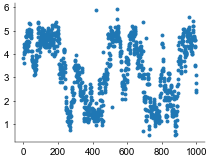

In [26]:
#X_loc, X_std = glm.input_group.input_0.variational(net_input=glm.likelihood.spikes[0])
#X_loc = glm.input_group.input_0.variational.mu.data.numpy()
#X_std = glm.input_group.input_0.variational.finv_std.data.numpy()

X_loc, X_str = glm.input_group.input_0.variational.eval_moments(0, resamples, None)
X_loc = X_loc.data.cpu().numpy()
X_str = X_str.data.cpu().numpy()

plt.scatter(np.arange(resamples), X_loc[:] % (2*np.pi))

In [148]:
model_name = 'GPLVM_T2'
checkpoint = torch.load('./checkpoint/' + model_name)
glm.load_state_dict(checkpoint['glm'])


grid_size = [40, 40]
grid_shape = [[0, 2*np.pi], [0, 2*np.pi]]

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = (x, y)
    return gp_lvm.eval_rate(covariates, np.arange(neurons)).reshape(neurons, *prevshape)

_, place_field = tools.compute_mesh(grid_size, grid_shape, func)


X_loc, X_std = gp_lvm.eval_X(net_input=glm.likelihood.spikes[0])
lat_t, shift, sign, _ = tools.shift_circ_traj(X_loc[0][:, 0], rhd_t, dev)
lat_t2, shift, sign, _ = tools.shift_circ_traj(X_loc[0][:, 1], rhd_t, dev)
lat_std = X_std[0][:, 0]
lat_std2 = X_std[0][:, 1]


T2len = glm.rate_model[0].kernel.kern1.lengthscale.flatten().data.cpu().numpy()
p_std = glm.rate_model[0].p_std_0.data.cpu().numpy()

2.5482655006769535
0.37000831121887806
2.937330599071589
2.6315421311097786


In [129]:
model_name = 'GPLVM_T1R1'
checkpoint = torch.load('./checkpoint/' + model_name)
glm.load_state_dict(checkpoint['glm'])

X_loc, X_std = gp_lvm.eval_X(net_input=glm.likelihood.spikes[0])
TRlat_t, shift, sign, _ = tools.shift_circ_traj(X_loc[0], rhd_t, dev)
TRlat_t2, shift, sign, TRscale, _ = tools.shift_traj(X_loc[1], rhd_t, dev)
TRlat_std = X_std[0]
TRlat_std2 = X_std[1]

TRlen_2 = glm.rate_model[0].kernel.kern1.lengthscale.flatten().data.cpu().numpy()
TRlen_1 = glm.rate_model[0].kernel.kern0.kern1.lengthscale.flatten().data.cpu().numpy()

3.2344176868666943
3.30380766302471
5.379968249444565
5.3799692416492455


In [149]:
pickle.dump((place_field, lat_t, lat_t2, lat_std, lat_std2, T2len, p_std, TRlen_2, TRlen_1, TRscale, tbin, rhd_t), open('./output/P1.p', 'wb'))

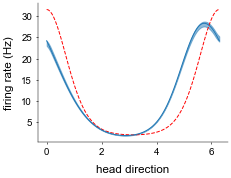

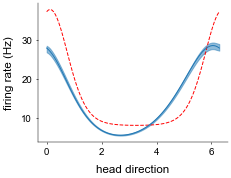

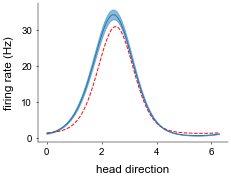

ModuleAttributeError: 'KCP_SVGP' object has no attribute 'eval_tuning'

NameError: name 'wrap_lat_t' is not defined

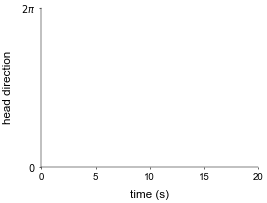

In [30]:
T = 1000

fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim([0, tbin*T])
ax.set_ylim([0, 2*np.pi])
ax.set_yticks([0, 2*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$'])
ax.set_xlabel('time (s)')
ax.set_ylabel('head direction')


ax.errorbar(tbin*np.arange(T), wrap_lat_t[:T], yerr=lat_std[:T], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5 ,label='var. dist.')

X__ = wrap_lat_t[:T]+lat_std[:T]
a = np.where(X__ > 2*np.pi)[0]
ax.errorbar(tbin*np.arange(T)[a], wrap_lat_t[a]-2*np.pi, yerr=lat_std[a], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5)

X__ = wrap_lat_t[:T]-lat_std[:T]
a = np.where(X__ < 0)[0]
ax.errorbar(tbin*np.arange(T)[a], wrap_lat_t[a]+2*np.pi, yerr=lat_std[a], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5)

ax.scatter(tbin*np.arange(T), rhd_t[:T], marker='.', color='r', zorder=2, label='true latents')

ax.legend()
plt.show()
